# MDP planning and inverse planning

In this notebook we will set up a simple grid-world, plan routes to goals, and infer goals given actions.

In [1]:
from functools import cache
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from memo import memo

H = 21
W = 21
S = np.arange(H * W)  # state space
G = np.array([0, H * W - 1])  # possible goals: NW and SE corners

A = np.array([0, 1, 2, 3])  # action space: left, right, up, down
coord_actions = np.array([[-1, 0], [+1, 0], [0, -1], [0, +1]])

maze_raw = np.array(1 - plt.imread('../paper/fig/logo-maze.png'), dtype=int);
maze = maze_raw.reshape(-1)
assert maze_raw.size == H * W

# # Alternatively...
# maze = np.zeros(H * W)  # blank maze

# transition function: P(s_ | s, a)
@jax.jit
def Tr(s, a, s_):
    x, y = s % W, s // W
    next_coords = np.array([x, y]) + coord_actions[a]
    next_state = (
        + 1 * np.clip(next_coords[0], 0, W - 1)
        + W * np.clip(next_coords[1], 0, H - 1)
    )
    return (
        + 1.0 * ((maze[next_state] == 0) & (next_state == s_))  # next state free, can move there
        + 1.0 * ((maze[next_state] == 1) & (s == s_)) # next state occupied, stay where you are
    )

# reward function
@jax.jit
def R(s, a, g):
    return 1.0 * (s == g) - 0.1

@jax.jit
def is_terminating(s, g):
    return s == g

# discount factor
@jax.jit
def gamma():
    return 1.0

We can plan via Q-value iteration and inverse-plan by inferring $P(g \mid s, a)$ where $P(a \mid s, g)$ is given by a softmax over Q-value with $\beta=2$.

In [2]:
@cache
@memo
def Q[s: S, a: A, g: G](t):
    alice: knows(s, a, g)
    alice: given(s_ in S, wpp=Tr(s, a, s_))
    alice: chooses(a_ in A, to_maximize=0.0 if t < 0 else Q[s_, a_, g](t - 1))
    return E[
        R(s, a, g) + (0.0 if t < 0 else
                      0.0 if is_terminating(s, g) else
                      gamma() * Q[alice.s_, alice.a_, g](t - 1))
    ]

@memo
def invplan[s: S, a: A, g: G](t):
    observer: knows(a, s, g)
    observer: thinks[
        alice: chooses(g in G, wpp=1),
        alice: knows(s),
        alice: chooses(a in A, wpp=exp(2 * Q[s, a, g](t))),
    ]
    observer: observes [alice.a] is a
    return observer[E[alice.g == g]]

Q(0)  # pre-compile Q
%timeit -r 1 -n 10 Q.cache_clear(); Q(1000).block_until_ready()
%timeit -r 1 -n 10 invplan(1000).block_until_ready()
ip = invplan(1000)
v = Q(1000).max(axis=1)

6.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4.66 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


This is already pretty fast, though it is even faster on a GPU.

Finally, let's make the plots shown in the paper.

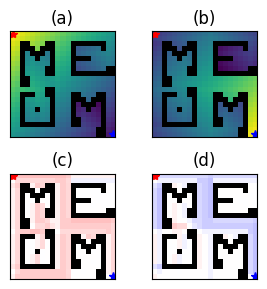

In [3]:
plt.figure(figsize=(3, 3))

plt.subplot(2, 2, 1)
plt.imshow((v[:, 0].reshape(H, W)))
plt.imshow(1 - maze_raw, cmap='gray', alpha=1. * maze_raw)
plt.plot([0], [0], 'r*')
plt.plot([20], [20], 'b*')
plt.xticks([]); plt.yticks([])
plt.title('(a)')

plt.subplot(2, 2, 2)
plt.imshow((v[:, 1].reshape(H, W)))
plt.imshow(1 - maze_raw, cmap='gray', alpha=1. * maze_raw)
plt.xticks([]); plt.yticks([])
plt.plot([0], [0], 'r*')
plt.plot([20], [20], 'b*')
plt.title('(b)')

dip = ip[:, :, 0] - ip[:, :, 1]
plt.subplot(2, 2, 3)
plt.imshow(dip[:, 0].reshape(H, W), cmap='bwr', vmin=-1, vmax=+1)
plt.imshow(1 - maze_raw, cmap='gray', alpha=1. * maze_raw)
plt.xticks([]); plt.yticks([])
plt.plot([0], [0], 'r*')
plt.plot([20], [20], 'b*')
plt.title('(c)')

plt.subplot(2, 2, 4)
plt.imshow(dip[:, 3].reshape(H, W), cmap='bwr', vmin=-1, vmax=+1)
plt.imshow(1 - maze_raw, cmap='gray', alpha=1. * maze_raw)
plt.xticks([]); plt.yticks([])
plt.plot([0], [0], 'r*')
plt.plot([20], [20], 'b*')
plt.title('(d)')

plt.tight_layout()

plt.savefig('../paper/fig/mdp.pdf')